With this notebook you can reproduce the results from the paper **X-ray irradiation and evaporation of the four young planets around V1298 Tau**

# Import

In [3]:
import sys
sys.path.append('../platypos_package/')

# Planet Class
from Planet_class_LoFo14_PAPER import planet_LoFo14_PAPER # this is the code with fixed step size
from Planet_class_LoFo14 import planet_LoFo14 # this is the code with variable step size
from Planet_class_Ot20_PAPER import planet_Ot20_PAPER # this is the code with fixed step size
from Planet_class_Ot20 import planet_Ot20  # this is the code with variable step size
import Planet_models_LoFo14 as plmo14
import Planet_model_Ot20 as plmoOt20
from Lx_evo_and_flux import Lx_evo, flux_at_planet_earth

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 14})
mpl.rcParams['axes.linewidth'] = 1.1 #set the value globally
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.ticker as ticker
import os
from astropy import constants as const
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from PyAstronomy import pyasl

p = "../supplementary_files/"
# Tu et al. (2015) - model tracks
blueTu15 = pd.read_csv(p+'Lx_blue_track.csv')
redTu15 = pd.read_csv(p+'Lx_red_track.csv')
greenTu15 = pd.read_csv(p+'Lx_green_track.csv')
                    
# Jackson et al. (2012) - Lx sample

def read_results_file(path, filename):
    # read in results files
    df = pd.read_csv(path+filename)
    t, M, R, Lx = df["Time"].values, df["Mass"].values, df["Radius"].values, df["Lx"].values
    return t, M, R, Lx

## V1298 Tau parameters, evolutionary tracks & create LoFo14 & Ot20 planet instances

First we need to define all the necessary system parameters. <br>
This includes the host star, the parameters of the evolutionary tracks, and the planets themselves.

In [27]:
L_sun = const.L_sun
L_bol = 0.934 # David et al. 2019
mass_star = 1.101
radius_star = 1.345
age_star = 23. # Myr
Lx_age = Lx_chandra = 1.3e30
Lx_age_error = 1.4e29

# use dictionary to store star-parameters
star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age}
age = star_V1298Tau["age"]
# create dictionaries with all the values necessary to create the evolutionary paths
Lx_1Gyr = 2.10*10**28  # Lx value at 1 Gyr from Tu et al. (2015) model tracks
Lx_5Gyr = 1.65*10**27  # Lx value at 5 Gyr from Tu et al. (2015) model tracks

track1 = {"t_start": age, "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2 = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2_2 = {"t_start": age, "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
track2_3 = {"t_start": age, "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3 = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}

track1_lower = {"t_start": age, "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2_lower = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2_2_lower = {"t_start": age, "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
track2_3_lower = {"t_start": age, "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3_lower = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}

track1_upper = {"t_start": age, "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2_upper = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2_2_upper = {"t_start": age, "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
track2_3_upper = {"t_start": age, "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3_upper = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}


# 'fluffy' LoFo14 planets with 5 M_earth core
planet_c_5 = {"core_mass": 5.0, "radius": 5.59, "distance": 0.0825, "metallicity": "solarZ"}
planet_d_5 = {"core_mass": 5.0, "radius": 6.41, "distance": 0.1083, "metallicity": "solarZ"}
planet_b_5 = {"core_mass": 5.0, "radius": 10.27, "distance": 0.1688, "metallicity": "solarZ"}
planet_e_5 = {"core_mass": 5.0, "radius": 8.74, "distance": 0.308, "metallicity": "solarZ"}

# 'fluffy' LoFo14 planets with 10 M_earth core
planet_c_10 = {"core_mass": 10.0, "radius": 5.59, "distance": 0.0825, "metallicity": "solarZ"}
planet_d_10 = {"core_mass": 10.0, "radius": 6.41, "distance": 0.1083, "metallicity": "solarZ"}
planet_b_10 = {"core_mass": 10.0, "radius": 10.27, "distance": 0.1688, "metallicity": "solarZ"}
planet_e_10 = {"core_mass": 10.0, "radius": 8.74, "distance": 0.308, "metallicity": "solarZ"}

# 'high-density' Ot20 planets
planet_c_Ot = {"radius": 5.59, "distance": 0.0825}
planet_d_Ot = {"radius": 6.41, "distance": 0.1083}
planet_b_Ot = {"radius": 10.27, "distance": 0.1688}
planet_e_Ot = {"radius": 8.74, "distance": 0.308}

## Plot current V1298 Tau Lx & evolutionary tracks

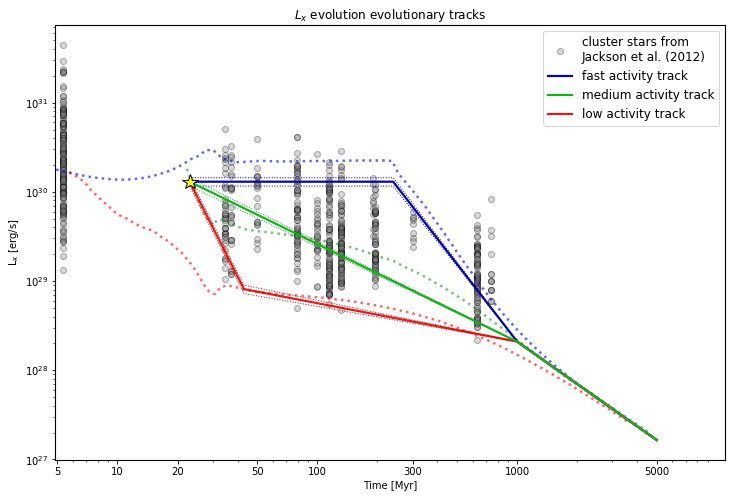

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('$L_x$ evolution evolutionary tracks')

ax.plot(blue[0], blue[1], marker="None", linestyle=":", color="blue", linewidth=2.5, alpha=0.6, label='_nolegend_')#, label="fast rot. (solar model)")
ax.plot(red[0], red[1], marker="None", linestyle=":", color="red", linewidth=2.5, alpha=0.6, label='_nolegend_')#, label="slow rot. (solar model)")
ax.plot(green[0], green[1], marker="None", linestyle=":", color="green", linewidth=2.5, alpha=0.5, label='_nolegend_')#, label="interm. rot. (solar model)")
ax.plot(jack["age"]/1e6, 10**jack["logLx_cgs"], ls="None", marker="o", color="grey", mec="k", alpha=0.3, zorder=1, label="cluster stars from \nJackson et al. (2012)")

#####################################################################
step_size = 1.
t_track_start = age
t_track_end = 5000.
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls="-", zorder=2, label="fast activity track", lw=2.2)
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls=":", zorder=2, label="__nolabel__", lw=1)

#####
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", zorder=3, lw=2.2, alpha=1., label="medium activity track")
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", ls=":", zorder=2, label="__nolabel__", lw=1)
#####
# t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
# Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_2) for t_i in t_arr])
# ax.plot(t_arr, Lx_arr, color="green", zorder=3, lw=2.2, alpha=1., label="medium activity track 2")
# #####
# t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
# Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_3) for t_i in t_arr])
# ax.plot(t_arr, Lx_arr, color="xkcd:orange", zorder=1, lw=2.2, alpha=1., label="100 Myr saturation")
#####
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", zorder=2, label="low activity track", alpha=0.9, ls="-", lw=2.2)
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", ls=":", zorder=2, label="__nolabel__", lw=1)
#####################################################################

ax.plot(age, Lx_age, marker="*", ms=16, color="yellow", mec="black", zorder=10)


ax.loglog()
ax.set_xlabel("Time [Myr]")
ax.set_ylabel("L$_\mathrm{x}$ [erg/s]")
ax.set_xticks([5, 10, 20, 50, 100, 300, 1000, 5000])
ax.set_yticks([10**27., 10**28., 10**29., 10**30., 10**31.])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xlim(left=4.9, right=11000)
ylim = ax.get_ylim()
ax.set_ylim(abs(ylim[0]), ylim[1])
ax.legend(loc="best", fontsize=12)
#plt.savefig("./tracks_v1298Tau.png", dpi=300)
plt.show()

# Evolve planets (code with variable step size)

## Lower Lx

### Evolve LoFo14 planets w. 10 Mcore with lower Lx

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new_lowerLx/10_Mcore/
CPU times: user 48.1 ms, sys: 0 ns, total: 48.1 ms
Wall time: 48 ms


### Evolve LoFo14 planets w. 5 Mcore  with lower Lx

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new_lowerLx/5_Mcore/
CPU times: user 73.6 ms, sys: 4 ms, total: 77.6 ms
Wall time: 77.7 ms


### Evolve Ot19 planets with lower Lx

In [49]:
%%time

star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age-Lx_age_error}
# variable step size
pl_c_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_c_Ot)
pl_d_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_d_Ot)
pl_b_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_b_Ot)
pl_e_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_e_Ot)

try:
    p = os.getcwd()+"/Otegi_results_lowerLx/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_lowerLx/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_Otl, M1_c_Otl, R1_c_Otl, Lx1_c_Otl = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_Otl, M2_c_Otl, R2_c_Otl, Lx2_c_Otl = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_Otl, M3_c_Otl, R3_c_Otl, Lx3_c_Otl = pl_c_Ot.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_Otl, M1_d_Otl, R1_d_Otl, Lx1_d_Otl = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_Otl, M2_d_Otl, R2_d_Otl, Lx2_d_Otl = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_Otl, M3_d_Otl, R3_d_Otl, Lx3_d_Otl = pl_d_Ot.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_Otl, M1_b_Otl, R1_b_Otl, Lx1_b_Otl = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_Otl, M2_b_Otl, R2_b_Otl, Lx2_b_Otl = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_Otl, M3_b_Otl, R3_b_Otl, Lx3_b_Otl = pl_b_Ot.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_Otl, M1_e_Otl, R1_e_Otl, Lx1_e_Otl = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_Otl, M2_e_Otl, R2_e_Otl, Lx2_e_Otl = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_Otl, M3_e_Otl, R3_e_Otl, Lx3_e_Otl = pl_e_Ot.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/Otegi_results_lowerLx/
CPU times: user 47.2 ms, sys: 7.99 ms, total: 55.2 ms
Wall time: 58.9 ms


## Upper Lx

### Evolve LoFo14 planets w. 10 Mcore with upper Lx

In [80]:
%%time

star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age+Lx_age_error}
# variable step size
pl_c_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c_5)
pl_d_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d_5)
pl_b_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b_5)
pl_e_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e_5)

try:
    p = os.getcwd()+"/LoFo14_Results_new_upperLx/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_new_upperLx/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_new_upperLx/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_new_upperLx/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_new_upperLx/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10u, M1_c_10u, R1_c_10u, Lx1_c_10u = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10u, M2_c_10u, R2_c_10u, Lx2_c_10u = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10u, M3_c_10u, R3_c_10u, Lx3_c_10u = pl_c_10.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10u, M1_d_10u, R1_d_10u, Lx1_d_10u = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10u, M2_d_10u, R2_d_10u, Lx2_d_10u = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10u, M3_d_10u, R3_d_10u, Lx3_d_10u = pl_d_10.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10u, M1_b_10u, R1_b_10u, Lx1_b_10u_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10u, M2_b_10u, R2_b_10u, Lx2_b_10u_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10u, M3_b_10u, R3_b_10u, Lx3_b_10u_2 = pl_b_10.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10u, M1_e_10u, R1_e_10u, Lx1_e_10u_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10u, M2_e_10u, R2_e_10u, Lx2_e_10u_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10u, M3_e_10u, R3_e_10u, Lx3_e_10u_2 = pl_e_10.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new_upperLx/10_Mcore/
CPU times: user 52.7 ms, sys: 4 ms, total: 56.7 ms
Wall time: 56.6 ms


### Evolve LoFo14 planets w. 5 Mcore  with upper Lx

In [48]:
%%time

star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age+Lx_age_error}
# variable step size
pl_c_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c_10)
pl_d_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d_10)
pl_b_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b_10)
pl_e_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e_10)

try:
    p = os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_new_upperLx/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)


# planet c
folder = folders[0]
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5u, M1_c_5u, R1_c_5u, Lx1_c_5u = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5u, M2_c_5u, R2_c_5u, Lx2_c_5u = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5u, M3_c_5u, R3_c_5u, Lx3_c_5u = pl_c_5.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5u, M1_d_5u, R1_d_5u, Lx1_d_5u = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5u, M2_d_5u, R2_d_5u, Lx2_d_5u = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5u, M3_d_5u, R3_d_5u, Lx3_d_5u = pl_d_5.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5u, M1_b_5u, R1_b_5u, Lx1_b_5u_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5u, M2_b_5u, R2_b_5u, Lx2_b_5u_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5u, M3_b_5u, R3_b_5u, Lx3_b_5u_2 = pl_b_5.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5u, M1_e_5u, R1_e_5u, Lx1_e_5u_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5u, M2_e_5u, R2_e_5u, Lx2_e_5u_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5u, M3_e_5u, R3_e_5u, Lx3_e_5u_2 = pl_e_5.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new_upperLx/5_Mcore/
CPU times: user 74.7 ms, sys: 4 ms, total: 78.7 ms
Wall time: 78.2 ms


### Evolve Ot20 planets with upper Lx

In [131]:
%%time

star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age+Lx_age_error}
# variable step size
pl_c_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_c_Ot)
pl_d_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_d_Ot)
pl_b_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_b_Ot)
pl_e_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_e_Ot)

try:
    p = os.getcwd()+"/Otegi_results_upperLx/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_upperLx/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_Otu, M1_c_Otu, R1_c_Otu, Lx1_c_Otu = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_Otu, M2_c_Otu, R2_c_Otu, Lx2_c_Otu = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_Otu, M3_c_Otu, R3_c_Otu, Lx3_c_Otu = pl_c_Ot.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_Otu, M1_d_Otu, R1_d_Otu, Lx1_d_Otu = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_Otu, M2_d_Otu, R2_d_Otu, Lx2_d_Otu = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_Otu, M3_d_Otu, R3_d_Otu, Lx3_d_Otu = pl_d_Ot.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_Otu, M1_b_Otu, R1_b_Otu, Lx1_b_Otu = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_Otu, M2_b_Otu, R2_b_Otu, Lx2_b_Otu = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_Otu, M3_b_Otu, R3_b_Otu, Lx3_b_Otu = pl_b_Ot.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_Otu, M1_e_Otu, R1_e_Otu, Lx1_e_Otu = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_Otu, M2_e_Otu, R2_e_Otu, Lx2_e_Otu = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_Otu, M3_e_Otu, R3_e_Otu, Lx3_e_Otu = pl_e_Ot.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/Otegi_results_upperLx/
CPU times: user 37.5 ms, sys: 0 ns, total: 37.5 ms
Wall time: 37.1 ms


# Read in results for Lx

## LoFo14 - Mcore10

In [82]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_new/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_new/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_new/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_new/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_new/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10, M1_c_10, R1_c_10, Lx1_c_10 = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10, M2_c_10, R2_c_10, Lx2_c_10 = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10, M3_c_10, R3_c_10, Lx3_c_10 = pl_c_10.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10, M1_d_10, R1_d_10, Lx1_d_10 = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10, M2_d_10, R2_d_10, Lx2_d_10 = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10, M3_d_10, R3_d_10, Lx3_d_10 = pl_d_10.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10, M1_b_10, R1_b_10, Lx1_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10, M2_b_10, R2_b_10, Lx2_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10, M3_b_10, R3_b_10, Lx3_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10, M1_e_10, R1_e_10, Lx1_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10, M2_e_10, R2_e_10, Lx2_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10, M3_e_10, R3_e_10, Lx3_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new/10_Mcore/
CPU times: user 46.1 ms, sys: 0 ns, total: 46.1 ms
Wall time: 45.1 ms


## LoFo14 - Mcore5

In [72]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_new/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_new/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_new/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_new/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_new/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5, M1_c_5, R1_c_5, Lx1_c_5 = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5, M2_c_5, R2_c_5, Lx2_c_5 = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5, M3_c_5, R3_c_5, Lx3_c_5 = pl_c_5.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5, M1_d_5, R1_d_5, Lx1_d_5 = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5, M2_d_5, R2_d_5, Lx2_d_5 = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5, M3_d_5, R3_d_5, Lx3_d_5 = pl_d_5.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5, M1_b_5, R1_b_5, Lx1_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5, M2_b_5, R2_b_5, Lx2_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5, M3_b_5, R3_b_5, Lx3_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5, M1_e_5, R1_e_5, Lx1_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5, M2_e_5, R2_e_5, Lx2_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5, M3_e_5, R3_e_5, Lx3_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/LoFo14_Results_new/5_Mcore/
CPU times: user 80.2 ms, sys: 8 ms, total: 88.2 ms
Wall time: 88.5 ms


## Ot20 

In [71]:
%%time
try:
    p = os.getcwd()+"/Otegi_results_new/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_new/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_Ot, M1_c_Ot, R1_c_Ot, Lx1_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_Ot, M2_c_Ot, R2_c_Ot, Lx2_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_Ot, M3_c_Ot, R3_c_Ot, Lx3_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_Ot, M1_d_Ot, R1_d_Ot, Lx1_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_Ot, M2_d_Ot, R2_d_Ot, Lx2_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_Ot, M3_d_Ot, R3_d_Ot, Lx3_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_Ot, M1_b_Ot, R1_b_Ot, Lx1_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_Ot, M2_b_Ot, R2_b_Ot, Lx2_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_Ot, M3_b_Ot, R3_b_Ot, Lx3_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_Ot, M1_e_Ot, R1_e_Ot, Lx1_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_Ot, M2_e_Ot, R2_e_Ot, Lx2_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_Ot, M3_e_Ot, R3_e_Ot, Lx3_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/plaml/example_V1298Tau/Otegi_results_new/
CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 31 ms


# Differences between upper and lower Lx_age

## Planet c

In [166]:
Lx_up = Lx_age+Lx_age_error
Lx = Lx_age
Lx_lo = Lx_age-Lx_age_error

def calc_fenv(M_tot, M_core):
    return ((M_tot-M_core)/M_tot)*100


dfc = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfc.loc[0] = [Lx_up, t1_c_5u[-1], t2_c_5u[-1], t3_c_5u[-1], 
              M1_c_5u[0], calc_fenv(M1_c_5u[0], 5.0), M1_c_5u[-1], calc_fenv(M1_c_5u[-1], 5.0), 
              M2_c_5u[-1], calc_fenv(M2_c_5u[-1], 5.0), M3_c_5u[-1], calc_fenv(M3_c_5u[-1], 5.0), 
              R1_c_5u[0], R1_c_5u[-1], R2_c_5u[-1], R3_c_5u[-1]]
dfc.loc[1] = [Lx, t1_c_5[-1], t2_c_5[-1], t3_c_5[-1], 
              M1_c_5[0], calc_fenv(M1_c_5[0], 5.0), M1_c_5[-1], calc_fenv(M1_c_5[-1], 5.0), 
              M2_c_5[-1], calc_fenv(M2_c_5[-1], 5.0), M3_c_5[-1], calc_fenv(M3_c_5[-1], 5.0), 
              R1_c_5[0], R1_c_5[-1], R2_c_5[-1], R3_c_5[-1]]
dfc.loc[2] = [Lx_lo, t1_c_5l[-1], t2_c_5l[-1], t3_c_5l[-1], 
              M1_c_5l[0], calc_fenv(M1_c_5l[0], 5.0), M1_c_5l[-1], calc_fenv(M1_c_5l[-1], 5.0), 
              M2_c_5l[-1], calc_fenv(M2_c_5l[-1], 5.0), M3_c_5l[-1], calc_fenv(M3_c_5l[-1], 5.0), 
              R1_c_5l[0], R1_c_5l[-1], R2_c_5l[-1], R3_c_5l[-1]]

dfc.loc[3] = [Lx_up, t1_c_10u[-1], t2_c_10u[-1], t3_c_10u[-1], 
              M1_c_10u[0], calc_fenv(M1_c_10u[0], 10.0), M1_c_10u[-1], calc_fenv(M1_c_10u[-1], 10.0), 
              M2_c_10u[-1], calc_fenv(M2_c_10u[-1], 10.0), M3_c_10u[-1], calc_fenv(M3_c_10u[-1], 10.0), 
              R1_c_10u[0], R1_c_10u[-1], R2_c_10u[-1], R3_c_10u[-1]]
dfc.loc[4] = [Lx, t1_c_10[-1], t2_c_10[-1], t3_c_10[-1], 
              M1_c_10[0], calc_fenv(M1_c_10[0], 10.0), M1_c_10[-1], calc_fenv(M1_c_10[-1], 10.0), 
              M2_c_10[-1], calc_fenv(M2_c_10[-1], 10.0), M3_c_10[-1], calc_fenv(M3_c_10[-1], 10.0), 
              R1_c_10[0], R1_c_10[-1], R2_c_10[-1], R3_c_10[-1]]
dfc.loc[5] = [Lx_lo, t1_c_10l[-1], t2_c_10l[-1], t3_c_10l[-1], 
              M1_c_10l[0], calc_fenv(M1_c_10l[0], 10.0), M1_c_10l[-1], calc_fenv(M1_c_10l[-1], 10.0), 
              M2_c_10l[-1], calc_fenv(M2_c_10l[-1], 10.0), M3_c_10l[-1], calc_fenv(M3_c_10l[-1], 10.0), 
              R1_c_10l[0], R1_c_10l[-1], R2_c_10l[-1], R3_c_10l[-1]]

dfc.loc[6] = [Lx_up, t1_c_Otu[-1], t2_c_Otu[-1], t3_c_Otu[-1], 
              M1_c_Otu[0], np.nan, M1_c_Otu[-1], np.nan, M2_c_Otu[-1], np.nan, M3_c_Otu[-1], np.nan, 
              R1_c_Otu[0], R1_c_Otu[-1], R2_c_Otu[-1], R3_c_Otu[-1]]
dfc.loc[7] = [Lx, t1_c_Ot[-1], t2_c_Ot[-1], t3_c_Ot[-1], 
              M1_c_Ot[0], np.nan, M1_c_Ot[-1], np.nan, M2_c_Ot[-1], np.nan, M3_c_Ot[-1], np.nan, 
              R1_c_Ot[0], R1_c_Ot[-1], R2_c_Ot[-1], R3_c_Ot[-1]]
dfc.loc[8] = [Lx_lo, t1_c_Otl[-1], t2_c_Otl[-1], t3_c_Otl[-1], 
              M1_c_Otl[0], np.nan, M1_c_Otl[-1], np.nan, M2_c_Otl[-1], np.nan, M3_c_Otl[-1], np.nan, 
              R1_c_Otl[0], R1_c_Otl[-1], R2_c_Otl[-1], R3_c_Otl[-1]]

dfc = dfc.round(3)
dfc

,Lx_init,t_final_high,t_final_med,t_final_low,M_init,fenv,M_final_high,fenv_high,M_final_med,fenv_med,M_final_low,fenv_low,R_init,R_final_high,R_final_med,R_final_low
0,1.440000e+30,51.88,85.3,927.9,5.401,7.421,5.000,0.0,5.000,0.000,5.000,0.000,5.59,1.495,1.495,1.495
1,1.300000e+30,54.90,95.9,1035.6,5.401,7.421,5.000,0.0,5.000,0.000,5.000,0.000,5.59,1.495,1.495,1.495
2,1.160000e+30,58.64,110.1,1165.9,5.401,7.421,5.000,0.0,5.000,0.000,5.000,0.000,5.59,1.495,1.495,1.495
3,1.440000e+30,176.00,5006.4,5007.1,10.922,8.446,10.000,0.0,10.104,1.028,10.337,3.262,5.59,1.778,2.397,2.995
4,1.300000e+30,192.80,5005.8,5000.3,10.922,8.446,10.000,0.0,10.117,1.157,10.351,3.388,5.59,1.778,2.441,3.022
5,1.160000e+30,213.80,5004.7,5002.4,10.922,8.446,10.000,0.0,10.132,1.302,10.365,3.521,5.59,1.778,2.489,3.051
6,1.440000e+30,5006.00,5007.0,5008.0,26.391,NaN,23.346,NaN,25.489,NaN,25.877,NaN,5.59,5.173,5.468,5.521
7,1.300000e+30,5007.00,5003.0,5007.0,26.391,NaN,23.564,NaN,25.522,NaN,25.890,NaN,5.59,5.203,5.473,5.523
8,1.160000e+30,5007.00,5010.0,5006.0,26.391,NaN,23.787,NaN,25.555,NaN,25.903,NaN,5.59,5.234,5.477,5.524


In [167]:
(dfc.M_init-dfc.M_final_high)/dfc.M_init

0    0.074246
1    0.074246
2    0.074246
3    0.084417
4    0.084417
5    0.084417
6    0.115380
7    0.107120
8    0.098670
dtype: float64

## Planet d

In [138]:
dfd = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfd.loc[0] = [Lx_up, t1_d_5u[-1], t2_d_5u[-1], t3_d_5u[-1], 
              M1_d_5u[0], calc_fenv(M1_d_5u[0], 5.0), M1_d_5u[-1], calc_fenv(M1_d_5u[-1], 5.0), 
              M2_d_5u[-1], calc_fenv(M2_d_5u[-1], 5.0), M3_d_5u[-1], calc_fenv(M3_d_5u[-1], 5.0), 
              R1_d_5u[0], R1_d_5u[-1], R2_d_5u[-1], R3_d_5u[-1]]
dfd.loc[1] = [Lx, t1_d_5[-1], t2_d_5[-1], t3_d_5[-1], 
              M1_d_5[0], calc_fenv(M1_d_5[0], 5.0), M1_d_5[-1], calc_fenv(M1_d_5[-1], 5.0), 
              M2_d_5[-1], calc_fenv(M2_d_5[-1], 5.0), M3_d_5[-1], calc_fenv(M3_d_5[-1], 5.0), 
              R1_d_5[0], R1_d_5[-1], R2_d_5[-1], R3_d_5[-1]]
dfd.loc[2] = [Lx_lo, t1_d_5l[-1], t2_d_5l[-1], t3_d_5l[-1], 
              M1_d_5l[0], calc_fenv(M1_d_5l[0], 5.0), M1_d_5l[-1], calc_fenv(M1_d_5l[-1], 5.0), 
              M2_d_5l[-1], calc_fenv(M2_d_5l[-1], 5.0), M3_d_5l[-1], calc_fenv(M3_d_5l[-1], 5.0), 
              R1_d_5l[0], R1_d_5l[-1], R2_d_5l[-1], R3_d_5l[-1]]

dfd.loc[3] = [Lx_up, t1_d_10u[-1], t2_d_10u[-1], t3_d_10u[-1], 
              M1_d_10u[0], calc_fenv(M1_d_10u[0], 10.0), M1_d_10u[-1], calc_fenv(M1_d_10u[-1], 10.0), 
              M2_d_10u[-1], calc_fenv(M2_d_10u[-1], 10.0), M3_d_10u[-1], calc_fenv(M3_d_10u[-1], 10.0), 
              R1_d_10u[0], R1_d_10u[-1], R2_d_10u[-1], R3_d_10u[-1]]
dfd.loc[4] = [Lx, t1_d_10[-1], t2_d_10[-1], t3_d_10[-1], 
              M1_d_10[0], calc_fenv(M1_d_10[0], 10.0), M1_d_10[-1], calc_fenv(M1_d_10[-1], 10.0), 
              M2_d_10[-1], calc_fenv(M2_d_10[-1], 10.0), M3_d_10[-1], calc_fenv(M3_d_10[-1], 10.0), 
              R1_d_10[0], R1_d_10[-1], R2_d_10[-1], R3_d_10[-1]]
dfd.loc[5] = [Lx_lo, t1_d_10l[-1], t2_d_10l[-1], t3_d_10l[-1], 
              M1_d_10l[0], calc_fenv(M1_d_10l[0], 10.0), M1_d_10l[-1], calc_fenv(M1_d_10l[-1], 10.0), 
              M2_d_10l[-1], calc_fenv(M2_d_10l[-1], 10.0), M3_d_10l[-1], calc_fenv(M3_d_10l[-1], 10.0), 
              R1_d_10l[0], R1_d_10l[-1], R2_d_10l[-1], R3_d_10l[-1]]

dfd.loc[6] = [Lx_up, t1_d_Otu[-1], t2_d_Otu[-1], t3_d_Otu[-1], 
              M1_d_Otu[0], np.nan, M1_d_Otu[-1], np.nan, M2_d_Otu[-1], np.nan, M3_d_Otu[-1], np.nan, 
              R1_d_Otu[0], R1_d_Otu[-1], R2_d_Otu[-1], R3_d_Otu[-1]]
dfd.loc[7] = [Lx, t1_d_Ot[-1], t2_d_Ot[-1], t3_d_Ot[-1], 
              M1_d_Ot[0], np.nan, M1_d_Ot[-1], np.nan, M2_d_Ot[-1], np.nan, M3_d_Ot[-1], np.nan, 
              R1_d_Ot[0], R1_d_Ot[-1], R2_d_Ot[-1], R3_d_Ot[-1]]
dfd.loc[8] = [Lx_lo, t1_d_Otl[-1], t2_d_Otl[-1], t3_d_Otl[-1], 
              M1_d_Otl[0], np.nan, M1_d_Otl[-1], np.nan, M2_d_Otl[-1], np.nan, M3_d_Otl[-1], np.nan, 
              R1_d_Otl[0], R1_d_Otl[-1], R2_d_Otl[-1], R3_d_Otl[-1]]

dfd = dfd.round(2)
dfd

,Lx_init,t_final_high,t_final_med,t_final_low,M_init,fenv,M_final_high,fenv_high,M_final_med,fenv_med,M_final_low,fenv_low,R_init,R_final_high,R_final_med,R_final_low
0,1.440000e+30,84.21,460.8,5001.9,5.60,10.67,5.00,0.00,5.00,0.00,5.03,0.50,6.41,1.50,1.50,1.95
1,1.300000e+30,90.80,577.3,5008.8,5.60,10.67,5.00,0.00,5.00,0.00,5.03,0.59,6.41,1.50,1.50,2.00
2,1.160000e+30,99.00,741.8,5006.5,5.60,10.67,5.00,0.00,5.00,0.00,5.03,0.68,6.41,1.50,1.50,2.05
3,1.440000e+30,1471.50,5008.5,5003.9,11.42,12.43,10.00,0.00,10.49,4.69,10.85,7.84,6.41,1.78,3.25,3.75
4,1.300000e+30,5008.50,5003.8,5008.2,11.42,12.43,10.01,0.08,10.52,4.92,10.87,7.99,6.41,1.91,3.29,3.77
5,1.160000e+30,5000.60,5007.7,5001.4,11.42,12.43,10.03,0.27,10.54,5.16,10.89,8.14,6.41,2.05,3.33,3.79
6,1.440000e+30,5008.00,5005.0,5003.0,32.76,NaN,30.74,NaN,32.17,NaN,32.43,NaN,6.41,6.16,6.34,6.37
7,1.300000e+30,5003.00,5003.0,5003.0,32.76,NaN,30.89,NaN,32.20,NaN,32.44,NaN,6.41,6.18,6.34,6.37
8,1.160000e+30,5003.00,5003.0,5003.0,32.76,NaN,31.04,NaN,32.22,NaN,32.45,NaN,6.41,6.19,6.34,6.37


## Planet b

In [139]:
dfb = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfb.loc[0] = [Lx_up, t1_b_5u[-1], t2_b_5u[-1], t3_b_5u[-1], 
              M1_b_5u[0], calc_fenv(M1_b_5u[0], 5.0), M1_b_5u[-1], calc_fenv(M1_b_5u[-1], 5.0), 
              M2_b_5u[-1], calc_fenv(M2_b_5u[-1], 5.0), M3_b_5u[-1], calc_fenv(M3_b_5u[-1], 5.0), 
              R1_b_5u[0], R1_b_5u[-1], R2_b_5u[-1], R3_b_5u[-1]]
dfb.loc[1] = [Lx, t1_b_5[-1], t2_b_5[-1], t3_b_5[-1], 
              M1_b_5[0], calc_fenv(M1_b_5[0], 5.0), M1_b_5[-1], calc_fenv(M1_b_5[-1], 5.0), 
              M2_b_5[-1], calc_fenv(M2_b_5[-1], 5.0), M3_b_5[-1], calc_fenv(M3_b_5[-1], 5.0), 
              R1_b_5[0], R1_b_5[-1], R2_b_5[-1], R3_b_5[-1]]
dfb.loc[2] = [Lx_lo, t1_b_5l[-1], t2_b_5l[-1], t3_b_5l[-1], 
              M1_b_5l[0], calc_fenv(M1_b_5l[0], 5.0), M1_b_5l[-1], calc_fenv(M1_b_5l[-1], 5.0), 
              M2_b_5l[-1], calc_fenv(M2_b_5l[-1], 5.0), M3_b_5l[-1], calc_fenv(M3_b_5l[-1], 5.0), 
              R1_b_5l[0], R1_b_5l[-1], R2_b_5l[-1], R3_b_5l[-1]]

dfb.loc[3] = [Lx_up, t1_b_10u[-1], t2_b_10u[-1], t3_b_10u[-1], 
              M1_b_10u[0], calc_fenv(M1_b_10u[0], 10.0), M1_b_10u[-1], calc_fenv(M1_b_10u[-1], 10.0), 
              M2_b_10u[-1], calc_fenv(M2_b_10u[-1], 10.0), M3_b_10u[-1], calc_fenv(M3_b_10u[-1], 10.0), 
              R1_b_10u[0], R1_b_10u[-1], R2_b_10u[-1], R3_b_10u[-1]]
dfb.loc[4] = [Lx, t1_b_10[-1], t2_b_10[-1], t3_b_10[-1], 
              M1_b_10[0], calc_fenv(M1_b_10[0], 10.0), M1_b_10[-1], calc_fenv(M1_b_10[-1], 10.0), 
              M2_b_10[-1], calc_fenv(M2_b_10[-1], 10.0), M3_b_10[-1], calc_fenv(M3_b_10[-1], 10.0), 
              R1_b_10[0], R1_b_10[-1], R2_b_10[-1], R3_b_10[-1]]
dfb.loc[5] = [Lx_lo, t1_b_10l[-1], t2_b_10l[-1], t3_b_10l[-1], 
              M1_b_10l[0], calc_fenv(M1_b_10l[0], 10.0), M1_b_10l[-1], calc_fenv(M1_b_10l[-1], 10.0), 
              M2_b_10l[-1], calc_fenv(M2_b_10l[-1], 10.0), M3_b_10l[-1], calc_fenv(M3_b_10l[-1], 10.0), 
              R1_b_10l[0], R1_b_10l[-1], R2_b_10l[-1], R3_b_10l[-1]]

dfb.loc[6] = [Lx_up, t1_b_Otu[-1], t2_b_Otu[-1], t3_b_Otu[-1], 
              M1_b_Otu[0], np.nan, M1_b_Otu[-1], np.nan, M2_b_Otu[-1], np.nan, M3_b_Otu[-1], np.nan, 
              R1_b_Otu[0], R1_b_Otu[-1], R2_b_Otu[-1], R3_b_Otu[-1]]
dfb.loc[7] = [Lx, t1_b_Ot[-1], t2_b_Ot[-1], t3_b_Ot[-1], 
              M1_b_Ot[0], np.nan, M1_b_Ot[-1], np.nan, M2_b_Ot[-1], np.nan, M3_b_Ot[-1], np.nan, 
              R1_b_Ot[0], R1_b_Ot[-1], R2_b_Ot[-1], R3_b_Ot[-1]]
dfb.loc[8] = [Lx_lo, t1_b_Otl[-1], t2_b_Otl[-1], t3_b_Otl[-1], 
              M1_b_Otl[0], np.nan, M1_b_Otl[-1], np.nan, M2_b_Otl[-1], np.nan, M3_b_Otl[-1], np.nan, 
              R1_b_Otl[0], R1_b_Otl[-1], R2_b_Otl[-1], R3_b_Otl[-1]]

dfb = dfb.round(2)
dfb

,Lx_init,t_final_high,t_final_med,t_final_low,M_init,fenv,M_final_high,fenv_high,M_final_med,fenv_med,M_final_low,fenv_low,R_init,R_final_high,R_final_med,R_final_low
0,1.440000e+30,280.7,5001.5,5006.9,7.56,33.88,5.00,0.00,5.27,5.16,5.92,15.50,10.27,1.50,3.22,4.72
1,1.300000e+30,336.2,5001.5,5007.9,7.56,33.88,5.00,0.00,5.30,5.69,5.96,16.13,10.27,1.50,3.32,4.79
2,1.160000e+30,467.0,5001.1,5002.8,7.56,33.88,5.00,0.00,5.34,6.31,6.01,16.80,10.27,1.50,3.43,4.86
3,1.440000e+30,5004.0,5006.0,5006.0,17.65,43.33,13.06,23.46,16.22,38.34,16.97,41.08,10.27,5.26,6.23,6.37
4,1.300000e+30,5006.0,5001.0,5005.0,17.65,43.33,13.36,25.15,16.29,38.60,17.00,41.18,10.27,5.39,6.24,6.37
5,1.160000e+30,5006.0,5005.0,5004.0,17.65,43.33,13.68,26.88,16.36,38.87,17.03,41.28,10.27,5.52,6.25,6.38
6,1.440000e+30,5003.0,5003.0,5003.0,69.00,NaN,67.60,NaN,68.59,NaN,68.77,NaN,10.27,10.14,10.23,10.25
7,1.300000e+30,5003.0,5003.0,5003.0,69.00,NaN,67.70,NaN,68.61,NaN,68.77,NaN,10.27,10.15,10.23,10.25
8,1.160000e+30,5003.0,5003.0,5003.0,69.00,NaN,67.81,NaN,68.62,NaN,68.78,NaN,10.27,10.16,10.23,10.25


## Planet e

In [140]:
dfe = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfe.loc[0] = [Lx_up, t1_e_5u[-1], t2_e_5u[-1], t3_e_5u[-1], 
              M1_e_5u[0], calc_fenv(M1_e_5u[0], 5.0), M1_e_5u[-1], calc_fenv(M1_e_5u[-1], 5.0), 
              M2_e_5u[-1], calc_fenv(M2_e_5u[-1], 5.0), M3_e_5u[-1], calc_fenv(M3_e_5u[-1], 5.0), 
              R1_e_5u[0], R1_e_5u[-1], R2_e_5u[-1], R3_e_5u[-1]]
dfe.loc[1] = [Lx, t1_e_5[-1], t2_e_5[-1], t3_e_5[-1], 
              M1_e_5[0], calc_fenv(M1_e_5[0], 5.0), M1_e_5[-1], calc_fenv(M1_e_5[-1], 5.0), 
              M2_e_5[-1], calc_fenv(M2_e_5[-1], 5.0), M3_e_5[-1], calc_fenv(M3_e_5[-1], 5.0), 
              R1_e_5[0], R1_e_5[-1], R2_e_5[-1], R3_e_5[-1]]
dfe.loc[2] = [Lx_lo, t1_e_5l[-1], t2_e_5l[-1], t3_e_5l[-1], 
              M1_e_5l[0], calc_fenv(M1_e_5l[0], 5.0), M1_e_5l[-1], calc_fenv(M1_e_5l[-1], 5.0), 
              M2_e_5l[-1], calc_fenv(M2_e_5l[-1], 5.0), M3_e_5l[-1], calc_fenv(M3_e_5l[-1], 5.0), 
              R1_e_5l[0], R1_e_5l[-1], R2_e_5l[-1], R3_e_5l[-1]]

dfe.loc[3] = [Lx_up, t1_e_10u[-1], t2_e_10u[-1], t3_e_10u[-1], 
              M1_e_10u[0], calc_fenv(M1_e_10u[0], 10.0), M1_e_10u[-1], calc_fenv(M1_e_10u[-1], 10.0), 
              M2_e_10u[-1], calc_fenv(M2_e_10u[-1], 10.0), M3_e_10u[-1], calc_fenv(M3_e_10u[-1], 10.0), 
              R1_e_10u[0], R1_e_10u[-1], R2_e_10u[-1], R3_e_10u[-1]]
dfe.loc[4] = [Lx, t1_e_10[-1], t2_e_10[-1], t3_e_10[-1], 
              M1_e_10[0], calc_fenv(M1_e_10[0], 10.0), M1_e_10[-1], calc_fenv(M1_e_10[-1], 10.0), 
              M2_e_10[-1], calc_fenv(M2_e_10[-1], 10.0), M3_e_10[-1], calc_fenv(M3_e_10[-1], 10.0), 
              R1_e_10[0], R1_e_10[-1], R2_e_10[-1], R3_e_10[-1]]
dfe.loc[5] = [Lx_lo, t1_e_10l[-1], t2_e_10l[-1], t3_e_10l[-1], 
              M1_e_10l[0], calc_fenv(M1_e_10l[0], 10.0), M1_e_10l[-1], calc_fenv(M1_e_10l[-1], 10.0), 
              M2_e_10l[-1], calc_fenv(M2_e_10l[-1], 10.0), M3_e_10l[-1], calc_fenv(M3_e_10l[-1], 10.0), 
              R1_e_10l[0], R1_e_10l[-1], R2_e_10l[-1], R3_e_10l[-1]]

dfe.loc[6] = [Lx_up, t1_e_Otu[-1], t2_e_Otu[-1], t3_e_Otu[-1], 
              M1_e_Otu[0], np.nan, M1_e_Otu[-1], np.nan, M2_e_Otu[-1], np.nan, M3_e_Otu[-1], np.nan, 
              R1_e_Otu[0], R1_e_Otu[-1], R2_e_Otu[-1], R3_e_Otu[-1]]
dfe.loc[7] = [Lx, t1_e_Ot[-1], t2_e_Ot[-1], t3_e_Ot[-1], 
              M1_e_Ot[0], np.nan, M1_e_Ot[-1], np.nan, M2_e_Ot[-1], np.nan, M3_e_Ot[-1], np.nan, 
              R1_e_Ot[0], R1_e_Ot[-1], R2_e_Ot[-1], R3_e_Ot[-1]]
dfe.loc[8] = [Lx_lo, t1_e_Otl[-1], t2_e_Otl[-1], t3_e_Otl[-1], 
              M1_e_Otl[0], np.nan, M1_e_Otl[-1], np.nan, M2_e_Otl[-1], np.nan, M3_e_Otl[-1], np.nan, 
              R1_e_Otl[0], R1_e_Otl[-1], R2_e_Otl[-1], R3_e_Otl[-1]]

dfe = dfe.round(2)
dfe

,Lx_init,t_final_high,t_final_med,t_final_low,M_init,fenv,M_final_high,fenv_high,M_final_med,fenv_med,M_final_low,fenv_low,R_init,R_final_high,R_final_med,R_final_low
0,1.440000e+30,5002.2,5005.4,5009.3,6.73,25.69,5.26,5.02,6.03,17.04,6.36,21.41,8.74,3.11,4.71,5.14
1,1.300000e+30,5000.2,5006.2,5009.6,6.73,25.69,5.31,5.76,6.05,17.41,6.38,21.58,8.74,3.24,4.75,5.15
2,1.160000e+30,5006.8,5006.8,5008.9,6.73,25.69,5.35,6.62,6.08,17.81,6.39,21.75,8.74,3.38,4.79,5.17
3,1.440000e+30,5005.0,5003.0,5010.0,14.63,31.66,13.64,26.71,14.34,30.28,14.50,31.01,8.74,5.31,5.55,5.59
4,1.300000e+30,5005.0,5010.0,5009.0,14.63,31.66,13.72,27.11,14.36,30.35,14.50,31.04,8.74,5.34,5.55,5.59
5,1.160000e+30,5005.0,5006.0,5008.0,14.63,31.66,13.80,27.51,14.37,30.42,14.51,31.07,8.74,5.37,5.55,5.59
6,1.440000e+30,5003.0,5003.0,5003.0,53.47,NaN,53.16,NaN,53.38,NaN,53.42,NaN,8.74,8.71,8.73,8.73
7,1.300000e+30,5003.0,5003.0,5003.0,53.47,NaN,53.18,NaN,53.39,NaN,53.42,NaN,8.74,8.71,8.73,8.73
8,1.160000e+30,5003.0,5003.0,5003.0,53.47,NaN,53.21,NaN,53.39,NaN,53.42,NaN,8.74,8.71,8.73,8.73


In [162]:
# concatenate all planets to one dataframe

df_all = pd.concat([dfc, dfd, dfb, dfe])
col_planet = ["c"]*9+["d"]*9+["b"]*9+["e"]*9
df_all.insert(0, 'planet', col_planet)
df_all.reset_index(drop=True, inplace=True)

df_all.to_csv("./results_Lx_errors.csv", index=None)

In [168]:
pd.read_csv("./results_Lx_errors.csv")

,planet,Lx_init,t_final_high,t_final_med,t_final_low,M_init,fenv,M_final_high,fenv_high,M_final_med,fenv_med,M_final_low,fenv_low,R_init,R_final_high,R_final_med,R_final_low
0,c,1.440000e+30,51.88,85.3,927.9,5.40,7.42,5.00,0.00,5.00,0.00,5.00,0.00,5.59,1.50,1.50,1.50
1,c,1.300000e+30,54.90,95.9,1035.6,5.40,7.42,5.00,0.00,5.00,0.00,5.00,0.00,5.59,1.50,1.50,1.50
2,c,1.160000e+30,58.64,110.1,1165.9,5.40,7.42,5.00,0.00,5.00,0.00,5.00,0.00,5.59,1.50,1.50,1.50
3,c,1.440000e+30,176.00,5006.4,5007.1,10.92,8.45,10.00,0.00,10.10,1.03,10.34,3.26,5.59,1.78,2.40,3.00
4,c,1.300000e+30,192.80,5005.8,5000.3,10.92,8.45,10.00,0.00,10.12,1.16,10.35,3.39,5.59,1.78,2.44,3.02
5,c,1.160000e+30,213.80,5004.7,5002.4,10.92,8.45,10.00,0.00,10.13,1.30,10.36,3.52,5.59,1.78,2.49,3.05
6,c,1.440000e+30,5006.00,5007.0,5008.0,26.39,NaN,23.35,NaN,25.49,NaN,25.88,NaN,5.59,5.17,5.47,5.52
7,c,1.300000e+30,5007.00,5003.0,5007.0,26.39,NaN,23.56,NaN,25.52,NaN,25.89,NaN,5.59,5.20,5.47,5.52
8,c,1.160000e+30,5007.00,5010.0,5006.0,26.39,NaN,23.79,NaN,25.55,NaN,25.90,NaN,5.59,5.23,5.48,5.52
9,d,1.440000e+30,84.21,460.8,5001.9,5.60,10.67,5.00,0.00,5.00,0.00,5.03,0.50,6.41,1.50,1.50,1.95


# Plots from the Paper

## Plot mass & radius evolution planet c

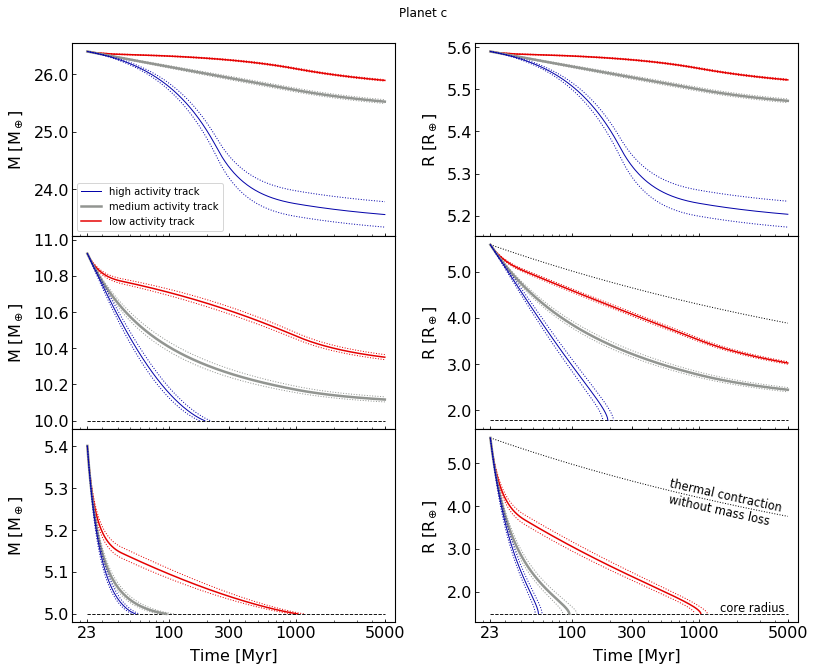

In [86]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet c")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_c_Otu, (M1_c_Otu), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_Otu, (M2_c_Otu), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 0].plot(t3_c_Otu, (M3_c_Otu), ls=":", color="xkcd:red", lw=1, zorder=1)

axs[0, 0].plot(t1_c_Ot, (M1_c_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_Ot, (M2_c_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_c_Ot, (M3_c_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[0, 0].plot(t1_c_Otl, (M1_c_Otl), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_Otl, (M2_c_Otl), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 0].plot(t3_c_Otl, (M3_c_Otl), ls=":", color="xkcd:red", lw=1, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_c_10u, (M1_c_10u), label=r"fast, step = 0.1 Myr", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10u, (M2_c_10u), label=r"med, step = 0.1 Myr", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 0].plot(t3_c_10u, (M3_c_10u), label=r"slow, step = 0.1 Myr", ls=":", color="xkcd:red", lw=1, zorder=1)
axs[1, 0].hlines(pl_c_10.core_mass, t1_c_10u[0], 5000., linestyle="--", color="k", lw=0.9)

axs[1, 0].plot(t1_c_10, (M1_c_10), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10, (M2_c_10), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_c_10, (M3_c_10), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[1, 0].plot(t1_c_10l, (M1_c_10l), label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10l, (M2_c_10l), label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 0].plot(t3_c_10l, (M3_c_10l), label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)


# 5Mcore
axs[2, 0].plot(t1_c_5u, (M1_c_5u), label=r"fast, step = 0.1 Myr", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5u, (M2_c_5u), label=r"med, step = 0.1 Myr", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 0].plot(t3_c_5u, (M3_c_5u), label=r"slow, step = 0.1 Myr", ls=":", color="xkcd:red", lw=1, zorder=1)
axs[2, 0].hlines(pl_c_5.core_mass, t1_c_5u[0], 5000., linestyle="--", color="k", lw=0.9)

axs[2, 0].plot(t1_c_5, (M1_c_5), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5, (M2_c_5), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_c_5, (M3_c_5), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[2, 0].plot(t1_c_5l, (M1_c_5l), label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5l, (M2_c_5l), label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 0].plot(t3_c_5l, (M3_c_5l), label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_c_Otu, (R1_c_Otu), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_Otu, (R2_c_Otu), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 1].plot(t3_c_Otu, (R3_c_Otu), ls=":", color="xkcd:red", lw=1, zorder=1)

axs[0, 1].plot(t1_c_Ot, (R1_c_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_Ot, (R2_c_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_c_Ot, (R3_c_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)


axs[0, 1].plot(t1_c_Otl, (R1_c_Otl), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_Otl, (R2_c_Otl), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 1].plot(t3_c_Otl, (R3_c_Otl), ls=":", color="xkcd:red", lw=1, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_c_10u, (R1_c_10u), label=r"fast, step = 0.1 Myr", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10u, (R2_c_10u), label=r"med, step = 0.1 Myr", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 1].plot(t3_c_10u, (R3_c_10u), label=r"slow, step = 0.1 Myr", ls=":", color="xkcd:red", lw=1, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10.core_mass, pl_c_10.fenv, age_arr, pl_c_10.flux, pl_c_10.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10.core_mass), pl_c_10.age, 5000., linestyle="--", color="k", lw=0.9)

axs[1, 1].plot(t1_c_10, (R1_c_10), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10, (R2_c_10), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_c_10, (R3_c_10), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[1, 1].plot(t1_c_10l, (R1_c_10l), label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10l, (R2_c_10l), label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 1].plot(t3_c_10l, (R3_c_10l), label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)

dy = 1.25
axs[2, 1].text(575, 3.19+dy, "thermal contraction", fontsize=11.5, rotation=-12.5)
axs[2, 1].text(570, 2.82+dy, "without mass loss", fontsize=11.5, rotation=-12.5)
#xkcd:goldenrod

# 5 mcore
axs[2, 1].plot(t1_c_5u, (R1_c_5u), label=r"fast track", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5u, (R2_c_5u), label=r"medim track", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 1].plot(t3_c_5u, (R3_c_5u), label=r"slow track", ls=":", color="xkcd:red", lw=1, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5.core_mass, pl_c_5.fenv, age_arr, pl_c_5.flux, pl_c_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5.core_mass), pl_c_5.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.55, "core radius", fontsize=11.5)

axs[2, 1].plot(t1_c_5, (R1_c_5), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5, (R2_c_5), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_c_5, (R3_c_5), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[2, 1].plot(t1_c_5l, (R1_c_5l), label=r"fast track", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5l, (R2_c_5l), label=r"medim track", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 1].plot(t3_c_5l, (R3_c_5l), label=r"slow track", ls=":", color="xkcd:red", lw=1, zorder=1)


axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
plt.savefig("./Plots/planet_c_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet d

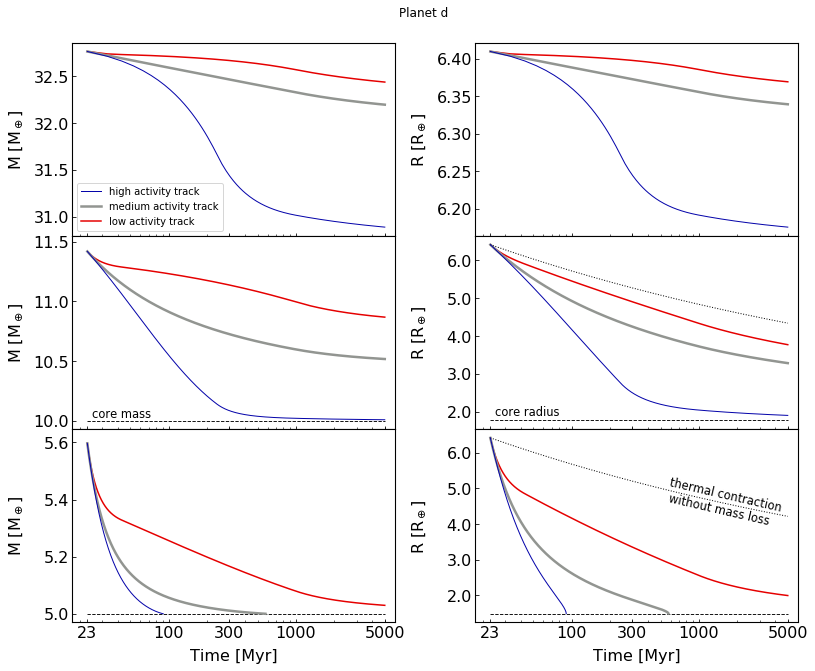

In [58]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet d")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_d_Ot, (M1_d_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_d_Ot, (M2_d_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_d_Ot, (M3_d_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_d_10P, (M1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_d_10P, (M2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_d_10P, (M3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t1_d_10P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_d_5P, (M1_d_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_d_5P, (M2_d_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_d_5P, (M3_d_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t1_d_5P[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_d_Ot, (R1_d_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_d_Ot, (R2_d_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_d_Ot, (R3_d_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_d_10P, (R1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_d_10P, (R2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_d_10P, (R3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10_PAPER.core_mass, pl_d_10_PAPER.fenv, age_arr, pl_d_10_PAPER.flux, pl_d_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10_PAPER.core_mass), pl_d_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=11.5)

# 5 mcore
axs[2, 1].plot(t1_d_5P, (R1_d_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_d_5P, (R2_d_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_d_5P, (R3_d_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5_PAPER.core_mass, pl_d_5_PAPER.fenv, age_arr, pl_d_5_PAPER.flux, pl_d_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 1.82
axs[2, 1].text(575, 3.25+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_d_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet b

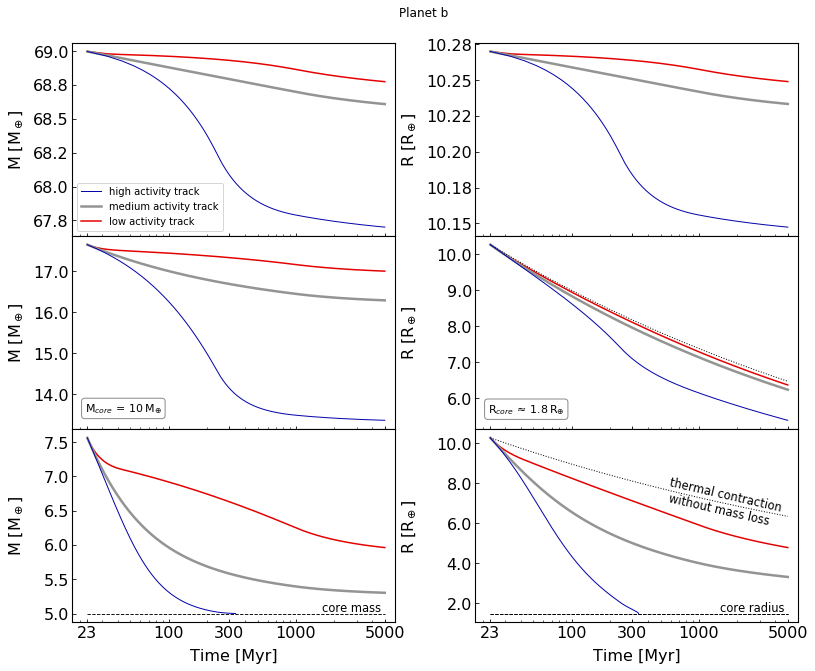

In [68]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet b")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_b_Ot, (M1_b_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_b_Ot, (M2_b_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_b_Ot, (M3_b_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_b_10P, (M1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_b_10P, (M2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_b_10P, (M3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_b_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_b_5P, (M1_b_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_b_5P, (M2_b_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_b_5P, (M3_b_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_b_5_PAPER.core_mass, t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_b_Ot, (R1_b_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_b_Ot, (R2_b_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_b_Ot, (R3_b_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_b_10P, (R1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_b_10P, (R2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_b_10P, (R3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_10_PAPER.core_mass, pl_b_10_PAPER.fenv, age_arr, pl_b_10_PAPER.flux, pl_b_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_b_5P, (R1_b_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_b_5P, (R2_b_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_b_5P, (R3_b_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_5_PAPER.core_mass, pl_b_5_PAPER.fenv, age_arr, pl_b_5_PAPER.flux, pl_b_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 4.27
axs[2, 1].text(575, 3.6+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.65, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.7, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_b_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet e

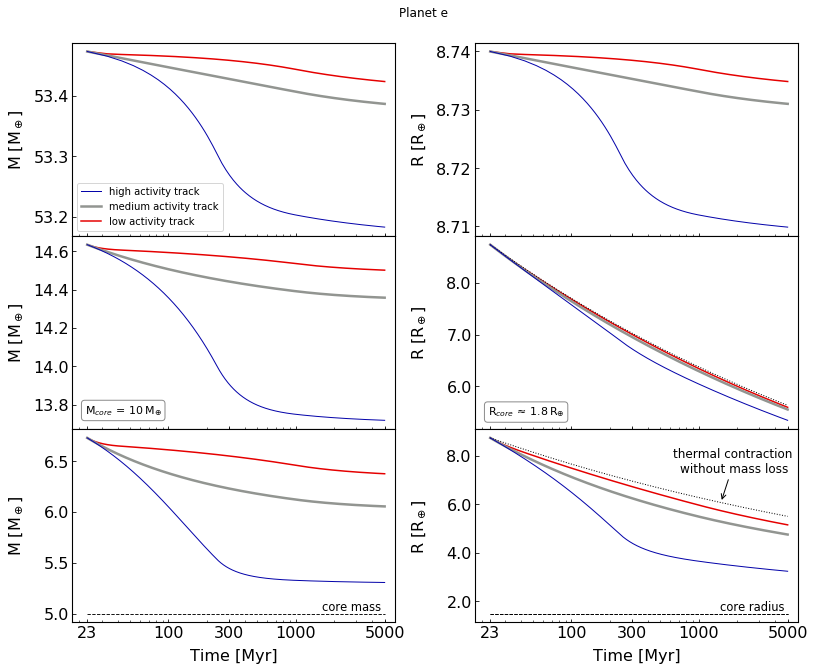

In [69]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet e")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_e_Ot, (M1_e_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_e_Ot, (M2_e_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_e_Ot, (M3_e_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_e_10P, (M1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_e_10P, (M2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_e_10P, (M3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_e_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_e_5P, (M1_e_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_e_5P, (M2_e_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_e_5P, (M3_e_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_e_5_PAPER.core_mass, t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_e_Ot, (R1_e_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_e_Ot, (R2_e_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_e_Ot, (R3_e_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_e_10P, (R1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_e_10P, (R2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_e_10P, (R3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_10_PAPER.core_mass, pl_e_10_PAPER.fenv, age_arr, pl_e_10_PAPER.flux, pl_e_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_e_5P, (R1_e_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_e_5P, (R2_e_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_e_5P, (R3_e_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_5_PAPER.core_mass, pl_e_5_PAPER.fenv, age_arr, pl_e_5_PAPER.flux, pl_e_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), pl_e_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 2.6
axs[2, 1].annotate('thermal contraction \nwithout mass loss', xy=(1500, 3.5+dy), xytext=(1900, 7.3), fontsize=12, ha='center',
            arrowprops=dict(arrowstyle="->"))
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.77, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.5, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_e_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Evolution of planets in the Radius-Period diagram

In [85]:
# Instantiate exoplanetEU2 object (download all the planets)
v = pyasl.ExoplanetEU2()
# Export all data as a pandas DataFrame
planets = v.getAllDataPandas()
planets_masses = planets[~np.isnan(planets["mass"])]

mask_nan = ~(np.isnan(planets["orbital_period"]) | np.isnan(planets["radius"]))
mask_P = planets["orbital_period"]<300
planets_ = planets[mask_nan & mask_P] # dataframe only with planets which have P & R

R_to_earth = 11.2
period = planets_["orbital_period"].values
radius = planets_["radius"].values*R_to_earth
ds = planets_["semi_major_axis"].values

# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

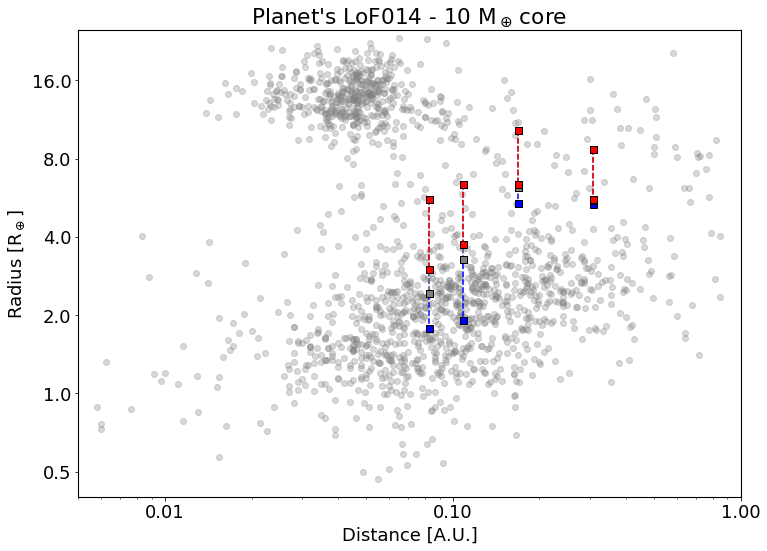

In [90]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Planet's LoF014 - 10 M$_\oplus\,$core")
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10[0], R1_c_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10[0], R2_c_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10[0], R3_c_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

# ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10_2[0], R1_c_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
# ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10_2[0], R2_c_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
# ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10_2[0], R3_c_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10[0], R1_d_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10[0], R2_d_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10[0], R3_d_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

# ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10_2[0], R1_d_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
# ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10_2[0], R2_d_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
# ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10_2[0], R3_d_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_b_10.distance, pl_b_10.distance], [R1_b_10[0], R1_b_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R2_b_10[0], R2_b_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R3_b_10[0], R3_b_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_10.distance, pl_e_10.distance], [R1_e_10[0], R1_e_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R2_e_10[0], R2_e_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R3_e_10[0], R3_e_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()

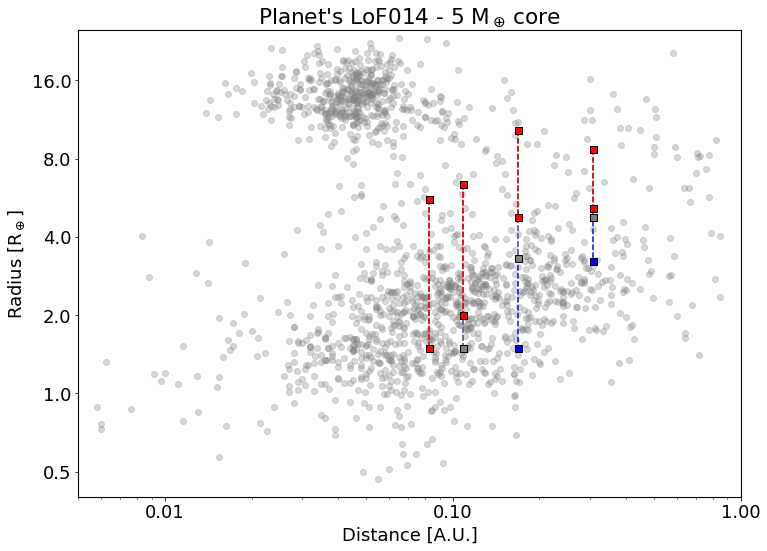

In [91]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Planet's LoF014 - 5 M$_\oplus\,$core")
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

ax.plot([pl_c_5.distance, pl_c_5.distance], [R1_c_5[0], R1_c_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_5.distance, pl_c_5.distance], [R2_c_5[0], R2_c_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_5.distance, pl_c_5.distance], [R3_c_5[0], R3_c_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

# ax.plot([pl_c_5.distance, pl_c_5.distance], [R1_c_5_2[0], R1_c_5_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
# ax.plot([pl_c_5.distance, pl_c_5.distance], [R2_c_5_2[0], R2_c_5_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
# ax.plot([pl_c_5.distance, pl_c_5.distance], [R3_c_5_2[0], R3_c_5_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_d_5.distance, pl_d_5.distance], [R1_d_5[0], R1_d_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_5.distance, pl_d_5.distance], [R2_d_5[0], R2_d_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_5.distance, pl_d_5.distance], [R3_d_5[0], R3_d_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

# ax.plot([pl_d_5.distance, pl_d_5.distance], [R1_d_5_2[0], R1_d_5_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
# ax.plot([pl_d_5.distance, pl_d_5.distance], [R2_d_5_2[0], R2_d_5_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
# ax.plot([pl_d_5.distance, pl_d_5.distance], [R3_d_5_2[0], R3_d_5_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_b_5.distance, pl_b_5.distance], [R1_b_5[0], R1_b_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_5.distance, pl_b_5.distance], [R2_b_5[0], R2_b_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_5.distance, pl_b_5.distance], [R3_b_5[0], R3_b_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_5.distance, pl_e_5.distance], [R1_e_5[0], R1_e_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_5.distance, pl_e_5.distance], [R2_e_5[0], R2_e_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_5.distance, pl_e_5.distance], [R3_e_5[0], R3_e_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()

# Addditional stuff

In [ ]:
t1, M1, R1, Lx1 = pl_c_10.read_results("./")

In [ ]:
t, M, R # my old code goes one time step further, i.e. to 192.9 -> CHECK WHY!
# -> old results: t_end = 192.90341377162815, M_end - 5.972364730419773e+28 = 10 M_earth, R_end = 1134204390.5169253 = 1.778 = R_core

In [14]:
R1[-1], R2[-1], R3[-1]

(1.7782794100389228, 2.441383425585101, 3.0223415552531763)

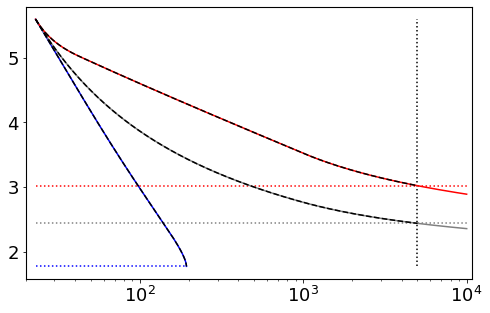

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t1_c_10_2, R1_c_10_2, c="blue")
ax.plot(t2_c_10_2, R2_c_10_2, c="grey")
ax.plot(t3_c_10_2, R3_c_10_2, c="red")

ax.plot(t1_c_10, R1_c_10, c="k", ls="--")
ax.plot(t2_c_10, R2_c_10, c="k", ls="--")
ax.plot(t3_c_10, R3_c_10, c="k", ls="--")

ax.vlines(5000, np.min(R1_c_10), np.max(R1_c_10), ls=":", color="k")
ax.hlines(np.min(R1_c_10), np.min(t1_c_10_2), np.max(t1_c_10_2), ls=":", color="blue")
ax.hlines(np.min(R2_c_10), np.min(t2_c_10_2), np.max(t2_c_10_2), ls=":", color="grey")
ax.hlines(np.min(R3_c_10), np.min(t3_c_10_2), np.max(t3_c_10_2), ls=":", color="red")

ax.set_xticks([20,100,300,1000])
ax.set_xlim(20,10800)
ax.set_xscale("log")
plt.show()

In [39]:
R1_d_10[-1], R2_d_10[-1], R3_d_10[-1]

(1.907746135292936, 3.285915447567908, 3.772635444773706)

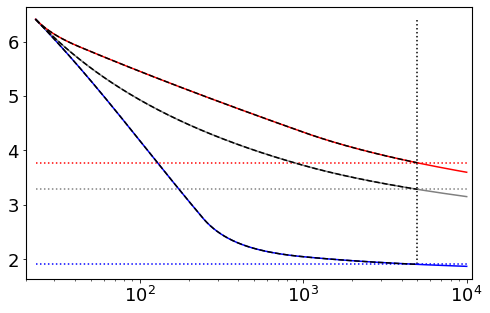

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t1_d_10_2, R1_d_10_2, c="blue")
ax.plot(t2_d_10_2, R2_d_10_2, c="grey")
ax.plot(t3_d_10_2, R3_d_10_2, c="red")

ax.plot(t1_d_10, R1_d_10, c="k", ls="--")
ax.plot(t2_d_10, R2_d_10, c="k", ls="--")
ax.plot(t3_d_10, R3_d_10, c="k", ls="--")

ax.vlines(5000, np.min(R1_d_10), np.max(R1_d_10), ls=":", color="k")
ax.hlines(np.min(R1_d_10), np.min(t1_d_10_2), np.max(t1_d_10_2), ls=":", color="blue")
ax.hlines(np.min(R2_d_10), np.min(t2_d_10_2), np.max(t2_d_10_2), ls=":", color="grey")
ax.hlines(np.min(R3_d_10), np.min(t3_d_10_2), np.max(t3_d_10_2), ls=":", color="red")

ax.set_xticks([20,100,300,1000])
ax.set_xlim(20,10800)
ax.set_xscale("log")
plt.show()

# Plot planet population

In [26]:
# Instantiate exoplanetEU2 object (download all the planets)
v = pyasl.ExoplanetEU2()
# Export all data as a pandas DataFrame
planets = v.getAllDataPandas()
planets_masses = planets[~np.isnan(planets["mass"])]

mask_nan = ~(np.isnan(planets["orbital_period"]) | np.isnan(planets["radius"]))
mask_P = planets["orbital_period"]<300
planets_ = planets[mask_nan & mask_P] # dataframe only with planets which have P & R

R_to_earth = 11.2
period = planets_["orbital_period"].values
radius = planets_["radius"].values*R_to_earth
ds = planets_["semi_major_axis"].values

# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

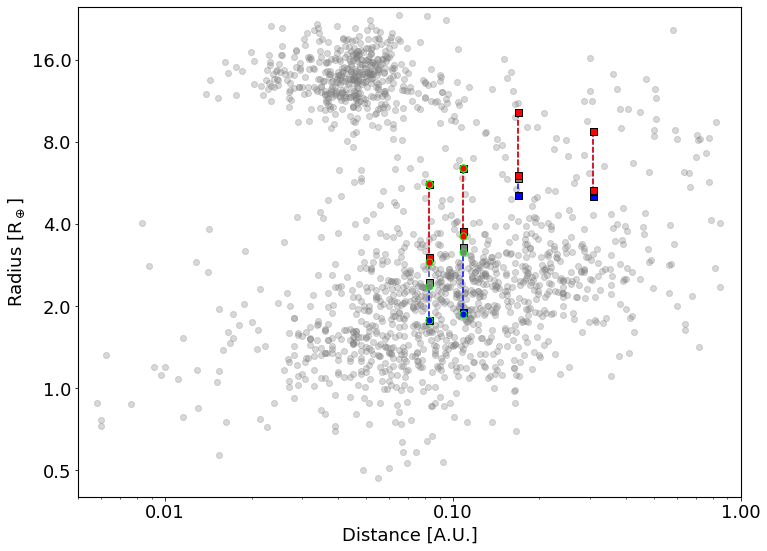

In [48]:
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

#ax.plot(planet_case1.distance, planet_case1.radius, marker="s", mec="k", color="aquamarine")
#ax.plot(planet_case1.distance, R1[-1], marker="s", mec="k", color="blue")
#ax.plot(planet_case1.distance, R2[-1], marker="s", mec="k", color="green")
#ax.plot(planet_case1.distance, R3[-1], marker="s", mec="k", color="darkred")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10[0], R1_c_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10[0], R2_c_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10[0], R3_c_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10_2[0], R1_c_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10_2[0], R2_c_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10_2[0], R3_c_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10[0], R1_d_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10[0], R2_d_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10[0], R3_d_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10_2[0], R1_d_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10_2[0], R2_d_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10_2[0], R3_d_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_b_10.distance, pl_b_10.distance], [R1_b_10[0], R1_b_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R2_b_10[0], R2_b_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R3_b_10[0], R3_b_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_10.distance, pl_e_10.distance], [R1_e_10[0], R1_e_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R2_e_10[0], R2_e_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R3_e_10[0], R3_e_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()